# Feedback Loops

A reusable deployment procees, with Docker images as templates, will save you, and those work closely with you, a lot of time. Feedback loops represent all of possible ways you can return to an earlier stage in the AI enterprise workflow.

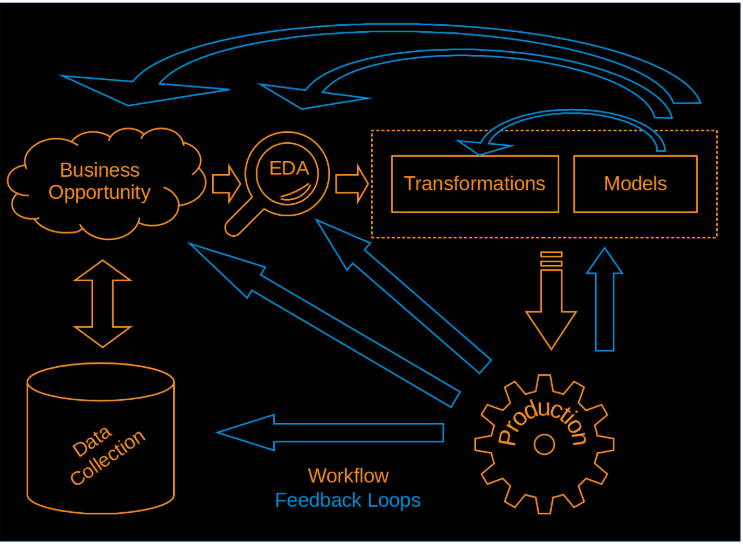

## Common feedback loops to keep in mind

**production -> business opportunity**
* The business opportunity that was refined and decided on in the beginning is in some ways a statement of purpose for your models. If a model has less of an impact on the business than originally anticipated this is often the first feedback loop that you will visit. It is a place to discuss the other potentially relevant feedback loops. Once all of the least time-consuming feedback loops have been explored this is also the place where you discuss the opportunity cost of continued workflow iteration.

**production -> data collection**
* This is a very common feedback loop especially when using deep-learning models. Because of their flexibility, neural networks can overfit a model. You may plot learning curves to help guide the decision to obtain more data. In some cases, obtaining more data means labeling more data which can be costly so ensure that you engage in discussions to determine the best course of action.

**production -> EDA**
* This is an important and often overlooked feedback loop. Once a model has been in production for some time, it becomes necessary to investigate the relationship between model performance and the business metric. This can be thought of as an extension of EDA, where visualization and hypothesis testing are the most important tools. Investigations into the underlying causes of model performance drift can re-purpose much of the code developed during EDA.

**production -> model selection and development**
* If a model performs poorly in production, perhaps due to latency issues or because there is an over-fitting issue, it is reasonable to return to try a different model. If it is an overfitting scenario and obtaining more data is not an option, choosing a model with lower complexity (e.g. SGDClassifier) is a reasonable next step. Spark ML models tend to have more latency than deployed scikit-learn models. Latency is the effective runtime for a prediction. You can run simulations to test different models, which can help optimize for latency. Another reason to return to the models stage from production is if we observe performance drift (a topic covered in the next unit).

There are other feedback loops such as trying different data transformations to improve a model's performance or optimizing the way data are collected to reduce the number of transformations that are necessary to run a machine learning model. The most aspect of all feedback loops is that they end with a return to a previous stage of the workflow. This is the only way to ensure that your entire workflow does not contain a weak link, and also the best way to keep track of each stage of the workflow.

# Unit Tests

Unit testing is the process of testing small portions of the software, also known as units. This is done one test at a time, to verify that an expected result is returned under controlled conditions. Importantly, the unit tests are usually organized as a suite and return objective evidence, in the form of a boolean value, which is a key element that enables workflow automation. The boolean value indicates whether or not each and every part of the software that was tested performed as expected. Ideally every portion of the code would be tested under every conceivable combination of conditions, however this is clearly not possible in the real world. The amount of source code that is actually tested when compared to the total amount of testable code is known as test coverage. There is even a package in Python called coverage that estimates the total coverage of your tests.

### Important
* There is an important trade-off in data science between the amount of test coverage and prioritizing other tasks. In many ways this trade-off is the same as the one that software engineers face, except data science has a sizable component of experimentation. This means that many models that get created never see production and many models that see production never come to fruition.

It is important to think about opportunity cost when determining the appropriate amount of test coverage. We will refer to the unit testing approach presented here as a test harness, because it is implemented as an automated test framework. Much like data ingestion, the idea is to have the necessary components of a task bundled under a single script. In this case it will be called `run-tests.py`. To help ensure that our unit tests are a test harness we will use the script to setup a hook.

One of the reasons to create unit tests is to ensure that iterative improvements to code do not break the functionality of the model or API. This is know as regression testing, because when the code does not perform as expected it is a regression. Including regression testing, here is a summary of the principal reasons to package unit tests with your deployed machine learning model:

* **Regression Testing:** ensure that previously developed and tested software still performs after a change
* **Code Quality:** promote the use of well-written code along with well-conceived designs
* **Documentation:** unit tests are a form of documentation that can help you and members of your team understand the details of how the software works, unit-by-unit
* **Automatic Performance Monitoring:** having a suite of unit tests that are kicked off when training is performed can help monitor for performance drift in an automated way

Unit tests also helps ensure that when software fails, it fails gracefully. This means it stops execution without causing additional errors and takes any steps, such as closing open connections or saving data to a file that may be necessary for recovery. This is an important aspect of software design that can save significant amounts of time when debugging a problematic query.

We will use the `unittest` library in this example. Here is a simple working example of how we will build tests.

In [1]:
%%writefile test-example.py

import unittest
import re
import numpy as np

## function or class to be tested
def slr_predict(x_query):
    """
    given a simple linear regression make a prediction for x
    """
    
    if isinstance(x_query, float):
        x_query = np.array([x_query])
    elif isinstance(x_query, str):
        if not re.search("\d+", x_query):
            raise Exception("non-numeric string input provided")
        x_query = np.array([float(x_query)])
    elif isinstance(x_query, list):
        x_query = np.array(x_query)
        
    ## generate data for linear regression
    x = np.array([0, 1, 2, 3, 4])
    y = np.array([-1, 0.15, 0.95, 2.1, 2.8])
    
    ## estimate the coeffs using lstsq
    A = np.vstack([x, np.ones(len(x))]).T
    coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return coeffs[0] + coeffs[1] * x_query

class TestSimpleLinearRegressionPredict(unittest.TestCase):
    
    ## example test method
    def test_numeric(self):
        y_pred = slr_predict(0.5)
        self.assertEqual(0.5, y_pred[0])
        
    def test_str(self):
        y_pred = slr_predict("0.5")
        self.assertEqual(0.5, y_pred[0])
        
    def test_list(self):
        y_pred = slr_predict([0.5, 0.1])
        self.assertEqual(0.5, y_pred[0])
        
    def test_array(self):
        y_pred = slr_predict(np.array([0.5,0.1]))
        self.assertEqual(0.5,y_pred[0])

Overwriting test-example.py


In [2]:
!python -m unittest test-example.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.709s

OK


Note the four small dots indicate four passing tests. If one of the tests had failed, you would see an ‘F’ in place of one of the dots, followed by additional information describing the test result and failure.

Notice that we are proactively trying to catch errors inside of the function. We used the Python regular expression module to help validate the input as it is a very useful tool for quality assurance on inputs. The are many types of built-in exceptions in Python. We simply use the generic `Exception` class in these examples. One way to further polish your code would be to use the closest matching exception class or to write your own class, inheriting from Exception.

The tests shown in the example above are unit tests because they are small. If one of the tests were more comprehensive, for example an API test that tested multiple functions, it would likely fall under the umbrella of integration testing. Both unit tests and integration tests are part of the CI/CD pipeline (see section below). There are several types of testing that can be used and the smaller, faster ones should be the most numerous, with the more comprehensive ones being fewer. The number of tests are often illustrated as a test pyramid.

# Test-Driven Development

Traditionally, software developers write software by first writing their functions, algorithms, classes, etc… and then, once they are satisfied that everything is working, they write a series of unit tests to provide objective evidence that it works as expected. The downside to this approach is that, without a defined completion criteria, it may result in writing more code than is necessary, and, without a clear definition of the expected outcome, the programmer might not know what completion criteria they are working towards until late in the process.

Test-Driven Development extends the idea of unit testing by recognizing that the sucessful completion of the test is the most important outcome of the software development process. Assuming the test is well-written and has sufficient coverage, any code that produces an ‘OK’ is ready for production; any code that does more than this is simply superfluous. TDD can have the same effect as using pseudocode to template a piece of software or a script before writing the code.

Test driven development or TDD is a software development technique where you will first write your unit tests. You have not yet written the necessary code to ensure that the tests will pass so they will all fail. Once all of the test are written, you will then write in a functional code so that the test pass.

In [3]:
%%writefile model.py

import time, os, re, csv, sys, uuid, joblib
from datetime import date
import numpy as np
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## model specific variables (iterate the version and note with each change)
MODEL_VERSION = 0.1
MODEL_VERSION_NOTE = "example SVM on toy data"
SAVED_MODEL = "model-{}.joblib".format(re.sub("\.","_",str(MODEL_VERSION)))

def fetch_data():
    """
    example function to fetch data for training
    """
    
    ## import some data to play with
    iris = datasets.load_iris()
    X = iris.data[:, :2]
    y = iris.target

    return X, y

def model_train(mode=None):
    """
    example function to train model
    
    "mode" - can be used to subset data essentially simulating a train
    """
    
    ## data ingestion
    X, y = fetch_data()
    
    ## perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    ## specify parameters and model
    params = {"C":1.0, "kernel":"linear", "gamma":0.5}
    clf = svm.SVC(**params, probability=True)
    
    ## fit model on trainig data
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    ## retrain using all data
    clf.fit(X, y)
    print("... saving model: {}".format(SAVED_MODEL))
    joblib.dump(clf, SAVED_MODEL)
    

def model_load():
    """
    example function to load model
    """
    
    if not os.path.exists(SAVED_MODEL):
        raise Exception("Model '{}' cannot be found did you train the model?".format(SAVED_MODEL))
        
    model = joblib.load(SAVED_MODEL)
    return model

def model_predict(query, model=None):
    """
    example function to predict from model
    """
    
    ## input check
    if isinstance(query, list):
        query = np.array([query])
    
    ## load model if needed
    if not model:
        model = model_load()
        
    ## output checking
    if len(query.shape) == 1:
        query = query.reshape(1, -1)
        
    ## make predictions adn gather data for log entry
    y_pred = model.predict(query)
    y_proba = None
    if "predict_proba" in dir(model) and model.probability == True:
        y_proba = model.predict_proba(query)
    
    return {"y_pred":y_pred, "y_proba":y_proba}

if __name__=="__main__":
    """
    basic test procedure for model.py
    """
    
    ## train the model
    model_train()
    
    ## load the model
    model = model_load()
    
    ## example predict
    for query in [np.array([[6.1, 2.8]]), np.array([[7.7, 2.5]]), np.array([[5.8, 3.8]])]:
        result = model_predict(query, model)
        y_pred = result["y_pred"]
        print("predicted: {}".format(y_pred))

Overwriting model.py


In [4]:
#! pip install joblib

In [5]:
! python model.py

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.67      0.53      0.59        15
           2       0.63      0.75      0.69        16

   micro avg       0.78      0.78      0.78        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.78      0.78      0.78        50

... saving model: model-0_1.joblib
predicted: [1]
predicted: [2]
predicted: [0]


Let's now write some unit tests to test the functions in the file model.py. Specifically we are using test driven development to harden the predict function to various inputs.

In [6]:
import os

if not os.path.exists("unittests"):
    os.makedirs("./unittests")
else:
    print("unittests directory already exists")

unittests directory already exists


In [7]:
%%writefile ./unittests/__init__.py

import unittest
import getopt
import sys
import os

## parse inputs
try:
    optlist, args = getopt.getopt(sys.argv[1:], "v")
except getopt.GetoptError:
    print(getopt.GetoptError)
    print(sys.argv[0] + "-v")
    print("... the verbose flag (-v) may be used")
    sys.exit()
    
VERBOSE = False
RUNALL = False

sys.path.append(os.path.realpath(os.path.dirname(__file__)))

for o, a in optlist:
    if o == "-v":
        VERBOSE = True
        
## model tests
from ModelTests import *
ModelTestSuite = unittest.TestLoader().loadTestsFromTestCase(ModelTest)

MainSuite = unittest.TestSuite([ModelTestSuite])

Overwriting ./unittests/__init__.py


In [8]:
%%writefile run-tests.py

import sys
import unittest

from unittests import *
unittest.main()

Overwriting run-tests.py


In [9]:
%%writefile ./unittests/ModelTests.py

"""
model tests
"""

import unittest
from model import *

class ModelTest(unittest.TestCase):
    """
    test the essential functionality
    """
    
    def test_01_train(self):
        """
        test the train functionality
        """
    
        ## train the model
        pass
        self.assertTrue(os.path.exists(SAVED_MODEL))
        
    def test_02_load(self):
        """
        test the train functionality
        """
        
        ## load the model
        pass
    
        self.assertTrue("predict" in dir(model))
        self.assertTrue("fit" in dir(model))
        
    def test_03_predict(self):
        """
        test the predict function input
        """
        
        ## load model first
        pass
    
        ## example predict
        query = [None, None]
        
        result = model_predict(query, model)
        y_pred = result["y_pred"]
        self.assertTrue(y_pred[0] in [0, 1, 2])
            
    def test_04_predict(self):
        """
        test the predict function accuracy
        """
        
        ## load model first
        pass
    
        ## example predict
        example_queries = [None, None, None]
        
        for query in example_queries:
            result = model_predict(query, model)
            y_pred = result["y_pred"]
            self.assertTrue(y_pred in [0, 1, 2])
            
## run the tests
if __name__ == "__main__":
    unittest.main()

Overwriting ./unittests/ModelTests.py


In [10]:
# ! python run-tests.py

In [11]:
%%writefile ./unittests/ModelTests.py

"""
model tests
"""

import unittest
from model import *

class ModelTest(unittest.TestCase):
    """
    test the essential functionality
    """
    
    def test_01_train(self):
        """
        test the train functionality
        """
    
        ## train the model
        model_train()
        
        self.assertTrue(os.path.exists(SAVED_MODEL))
        
    def test_02_load(self):
        """
        test the train functionality
        """
        
        ## load the model
        model = model_load()
    
        self.assertTrue("predict" in dir(model))
        self.assertTrue("fit" in dir(model))
        
    def test_03_predict(self):
        """
        test the predict function input
        """
        
        ## load model first
        model = model_load()
    
        ## example predict
        query = [6.1, 2.8]
        
        result = model_predict(query, model)
        y_pred = result["y_pred"]
        self.assertTrue(y_pred[0] in [0, 1, 2])
            
    def test_04_predict(self):
        """
        test the predict function accuracy
        """
        
        ## load model first
        model = model_load()
    
        ## example predict
        example_queries = [np.array([[6.1, 2.8]]), np.array([[7.7, 2.5]]), np.array([[5.8, 3.8]])]
        
        for query in example_queries:
            result = model_predict(query, model)
            y_pred = result["y_pred"]
            self.assertTrue(y_pred in [0, 1, 2])
            
## run the tests
if __name__ == "__main__":
    unittest.main()

Overwriting ./unittests/ModelTests.py


In [12]:
# ! python run-tests.py